<br>
<center><h1>Divvy Bike Trip Duration Prediction</h1></center>
<br>

# Objective & Key Points

Using 2017 Divvy Bikes data, I'd like to:<br>
- 1) study the patterns (i.e. the most popular routes, genearl usage, difference in sub-groups of users etc.) <br>
- 2) create a model (models) that predict trip duration. <br>
        Given a ride's start and end stations, some of the riders demographic data, some bike information, and potentially weather data, I'd like to predict how long the ride would take.

Some of the **key takeaways** from the analysis:

1. Distance is by far the most predictive among all variables. The longer the distance, the longer the trip duration.
- Other variables that are important and make sense are age (older the age, longer the duration), and gender (Males take slighly shorter time to finish trips).
2. Weather data can improve the model accuracy but only by a little bit.
3. Gradient boosted tree model with weather info is the most accurate (R-squared = 14.8%), and yet it is not that much better than without weather data (R-squared = 14.5%), or a linear model (R-squared = 13.1%).


Going forward, other feature engineering, other non-linear models, or even other external data can be explored to improve the performance.

<h1>Table of Content</h1>

>[Import Libraries](#Import-Libraries) <br>
[Read Data](#Read-Data) <br>
[1. Data Exploration](#1.-Data-Exploration)<br>
[__a. Data Source](#a.-Source:)<br>
[__b. Data Info](#b.-Data-Info:)<br>
[____b.1. Bike related info](#b.1.-Bike-related-info)<br>
[____b.2 missing data and missing pattern](#b.2-missing-data-and-missing-pattern)<br>
[____b.3 Distribution of each feature](#b.3-Distribution-of-each-feature)<br>
[2. Data Visualization](#2.-Data-Visualization)<br>
[3. Data Cleaning](#3.-Data-Cleaning)<br>
[____3.1 Data Exploration](#3.1-Data-Exploration)<br>
[____3.2 Feature Engineering](#3.2-Feature-Engineering)<br>
[4. Modeling](#4.-Modeling)<br>
- Linear basline model
- Gradient boosted tree model
- Linear basline model with weather data
- Gradient boosted tree model with weather data
- Random forest model<br>
<br>[Key Takeaways](#Key-Takeaways)
>

<a name="Import-Libraries"></a>
# Import Libraries

In [1]:
from zipfile import ZipFile
import os
import pandas as pd
import math
import numpy as np
from scipy import stats

import tarfile
import json
import sys
import datetime

import multiprocessing as mp
from multiprocessing import Pool
import dask.dataframe as dd

In [216]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import scale, StandardScaler

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Read Data

In [3]:
os.listdir("../data/raw")

['Divvy_Trips_2017_Q3Q4.zip', 'Divvy_Trips_2017_Q1Q2.zip']

In [4]:
file_path = "../data/raw/Divvy_Trips_2017_Q1Q2.zip"

In [5]:
archive = ZipFile("../data/raw/Divvy_Trips_2017_Q1Q2.zip", "r")

In [6]:
archive2 = ZipFile("../data/raw/Divvy_Trips_2017_Q3Q4.zip", "r")

In [9]:
archive.filelist

[<ZipInfo filename='Divvy_Trips_2017_Q1.csv' compress_type=deflate external_attr=0x20 file_size=67969331 compress_size=11913711>,
 <ZipInfo filename='Divvy_Stations_2017_Q1Q2.csv' compress_type=deflate external_attr=0x20 file_size=56223 compress_size=15552>,
 <ZipInfo filename='README.txt' compress_type=deflate external_attr=0x20 file_size=1513 compress_size=648>,
 <ZipInfo filename='Divvy_Trips_2017_Q2.csv' compress_type=deflate external_attr=0x20 file_size=174311015 compress_size=30097985>]

In [10]:
archive2.filelist

[<ZipInfo filename='Divvy_Stations_2017_Q3Q4.csv' compress_type=deflate external_attr=0x20 file_size=46340 compress_size=13108>,
 <ZipInfo filename='Divvy_Trips_2017_Q3.csv' compress_type=deflate external_attr=0x20 file_size=249752322 compress_size=42901701>,
 <ZipInfo filename='Divvy_Trips_2017_Q4.csv' compress_type=deflate external_attr=0x20 file_size=85943745 compress_size=14579301>,
 <ZipInfo filename='README.txt' compress_type=deflate external_attr=0x20 file_size=1514 compress_size=647>]

In [7]:
stops = pd.read_csv(archive.open('Divvy_Stations_2017_Q1Q2.csv'))

In [8]:
Q1 = pd.read_csv(archive.open('Divvy_Trips_2017_Q1.csv'), parse_dates=["start_time","end_time"])

In [9]:
Q2 = pd.read_csv(archive.open('Divvy_Trips_2017_Q2.csv'), parse_dates=["start_time","end_time"])

In [10]:
Q3 = pd.read_csv(archive2.open('Divvy_Trips_2017_Q3.csv'), parse_dates=["start_time","end_time"])

In [11]:
Q4 = pd.read_csv(archive2.open('Divvy_Trips_2017_Q4.csv'), parse_dates=["start_time","end_time"])

In [17]:
Q1.shape, Q2.shape, Q3.shape, Q4.shape

((431691, 12), (1119814, 12), (1608270, 12), (669239, 12))

In [12]:
stops.shape

(582, 7)

In [13]:
combined = Q1.append([Q2,Q3,Q4])

In [14]:
del Q1, Q2, Q3, Q4

# 1. Data Exploration

## a. Source:

Dataset 1: Divvy Bike data which can be found [here](https://www.divvybikes.com/system-data) <br>
Dataset 2: Chicago beach weather data which can be downloaded [here](https://data.cityofchicago.org/api/views/k7hf-8y75/rows.csv?accessType=DOWNLOAD)

In [16]:
combined.columns

Index(['trip_id', 'start_time', 'end_time', 'bikeid', 'tripduration',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear'],
      dtype='object')

In [15]:
combined.shape

(3829014, 12)

## b. Data Info:

### b.1. Bike related info

In [17]:
# unique number of bikes
combined.bikeid.nunique()

6243

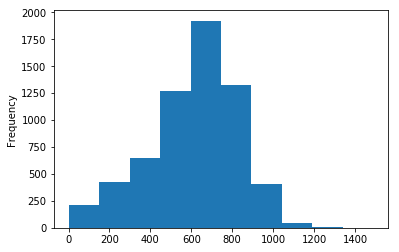

In [19]:
# bike usage histogram
combined.bikeid.value_counts().plot.hist()

Most bikes are used close to 2K times in 2017.

### b.2 missing data and missing pattern

In [22]:
combined.isnull().sum()/combined.shape[0]

trip_id              0.000000
start_time           0.000000
end_time             0.000000
bikeid               0.000000
tripduration         0.000000
from_station_id      0.000000
from_station_name    0.000000
to_station_id        0.000000
to_station_name      0.000000
usertype             0.000000
gender               0.218549
birthyear            0.218531
dtype: float64

In [27]:
combined.usertype.value_counts()

Subscriber    2992135
Customer       836872
Dependent           7
Name: usertype, dtype: int64

In [25]:
# most of the missing genders are from Customers
combined[combined.gender.isnull()].usertype.value_counts()

Customer      836018
Subscriber       806
Dependent          3
Name: usertype, dtype: int64

In [26]:
# most of the missing age are from Customers
combined[combined.birthyear.isnull()].usertype.value_counts()

Customer      836018
Subscriber       740
Name: usertype, dtype: int64

> Since most Customers are missing some demographic information, it might be best to exclude them from the model.

### b.3 Distribution of each feature
without the missing values

In [31]:
combined.columns

Index(['trip_id', 'start_time', 'end_time', 'bikeid', 'tripduration',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2548c9e8>,
      dtype=object)

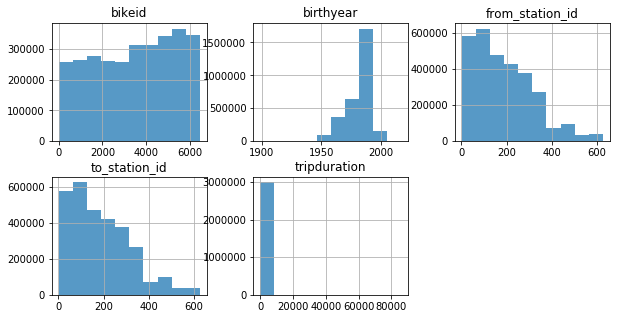

In [54]:
# all numeric values
combined[~combined.gender.isnull()].drop(['trip_id', 'start_time', 'end_time'], axis = 1)\
    .hist(figsize = (10,5), layout = (2,3), alpha = 0.75)

### - Distibution by usertype

In [67]:
combined.usertype.value_counts()

Subscriber    2992135
Customer       836872
Dependent           7
Name: usertype, dtype: int64

usertype
Customer      [[AxesSubplot(0.125,0.670278;0.103333x0.209722...
Dependent     [[AxesSubplot(0.125,0.670278;0.103333x0.209722...
Subscriber    [[AxesSubplot(0.125,0.670278;0.103333x0.209722...
dtype: object

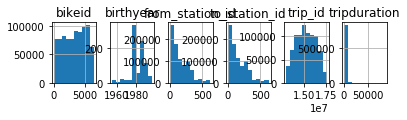

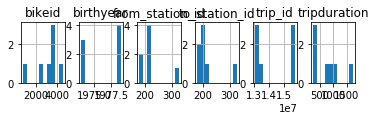

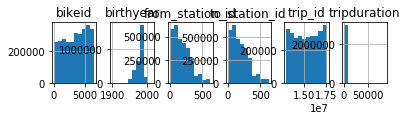

In [69]:
combined.groupby("usertype").hist(layout=(3,6), label = 'left')

In [82]:
combined.groupby("usertype").tripduration.describe()

,count,mean,std,min,25%,50%,75%,max
usertype,,,,,,,,
Customer,836872.0,1856.081443,2641.962013,60.0,924.0,1369.0,1937.0,86338.0
Dependent,7.0,751.857143,549.073896,237.0,277.5,804.0,959.0,1749.0
Subscriber,2992135.0,703.787619,953.771729,60.0,356.0,572.0,908.0,86096.0


In [83]:
# check if the difference in trip duration is significant
stats.ttest_ind(combined[combined.usertype == 'Customer']['tripduration'].dropna(),
                combined[combined.usertype == 'Subscriber']['tripduration'].dropna(),
               equal_var=False)

Ttest_indResult(statistic=391.91485346879017, pvalue=0.0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2d30f198>,
      dtype=object)

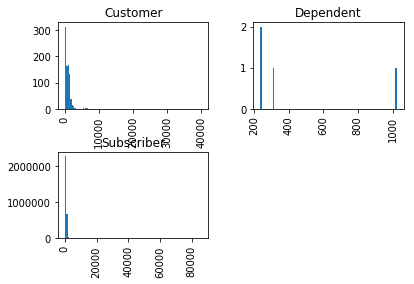

In [142]:
# trip duration by user types
combined[~combined.gender.isnull()]['tripduration']\
    .hist(by=combined[~combined.gender.isnull()]['usertype'], bins = 100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c202e1c50>,
      dtype=object)

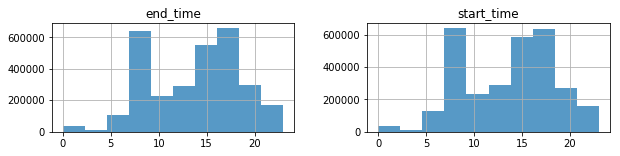

In [58]:
# trip hours
combined[~combined.gender.isnull()][['start_time', 'end_time']].applymap(lambda x: x.hour)\
    .hist(figsize = (10,2),alpha = 0.75)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2dc3a780>,
      dtype=object)

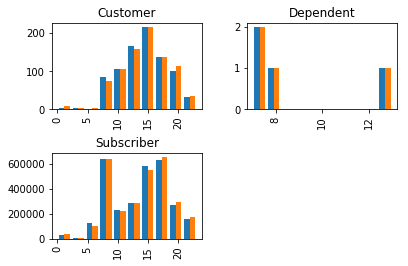

In [135]:
# trip hours by user types
combined[~combined.gender.isnull()][['start_time', 'end_time']].applymap(lambda x: x.hour)\
    .hist(by=combined[~combined.gender.isnull()]['usertype'])

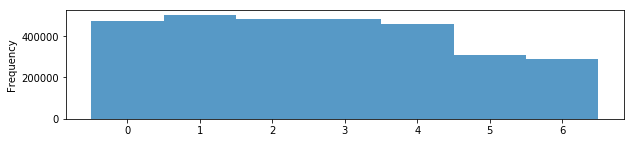

In [129]:
# trip weekdays
combined[~combined.gender.isnull()]['start_time'].dt.dayofweek\
    .plot.hist(figsize = (10,2),alpha = 0.75, align = 'mid', bins = np.arange(-.5, 7.5, 1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c31aa94a8>,
      dtype=object)

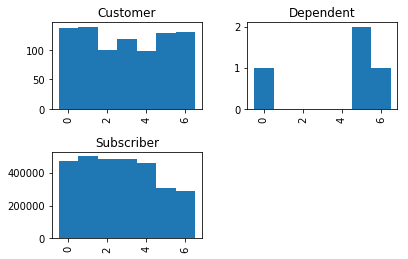

In [137]:
# trip weekdays by user types
combined[~combined.gender.isnull()]['start_time'].dt.dayofweek\
    .hist(by=combined[~combined.gender.isnull()]['usertype'], align = 'mid', bins = np.arange(-.5, 7.5, 1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c246a1cc0>,
      dtype=object)

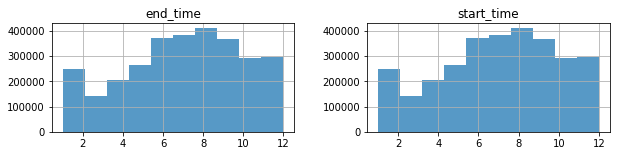

In [59]:
# trip months
combined[~combined.gender.isnull()][['start_time', 'end_time']].applymap(lambda x: x.month)\
    .hist(figsize = (10,2),alpha = 0.75)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2f1642e8>,
      dtype=object)

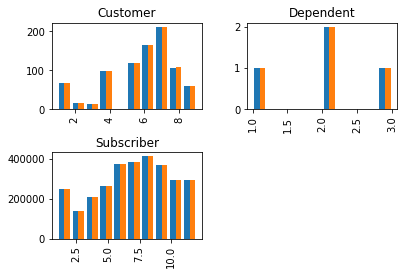

In [145]:
# trip weekdays by user types
combined[~combined.gender.isnull()][['start_time', 'end_time']].applymap(lambda x: x.month)\
    .hist(by=combined[~combined.gender.isnull()]['usertype'], align = 'mid')

### - Distribution by Gender

In [84]:
combined.groupby("gender").tripduration.describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,746637.0,783.368752,1069.983546,60.0,403.0,651.0,1013.0,85782.0
Male,2245550.0,677.193849,908.124183,60.0,343.0,549.0,871.0,86096.0


In [85]:
# check if the difference in trip duration is significant
stats.ttest_ind(combined[combined.gender == 'Female']['tripduration'].dropna(),
                combined[combined.gender == 'Male']['tripduration'].dropna(),
               equal_var=False)

Ttest_indResult(statistic=77.014866504553, pvalue=0.0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c32d83470>,
      dtype=object)

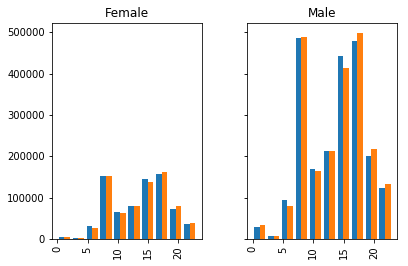

In [140]:
# trip hours by gender
combined[~combined.gender.isnull()][['start_time', 'end_time']].applymap(lambda x: x.hour)\
    .hist(by=combined[~combined.gender.isnull()]['gender'], sharey = True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2eab22b0>,
      dtype=object)

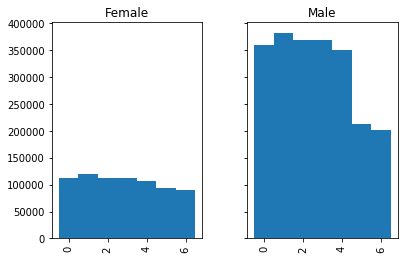

In [144]:
# trip weekdays by gender
combined[~combined.gender.isnull()]['start_time'].dt.dayofweek\
    .hist(by=combined[~combined.gender.isnull()]['gender'], align = 'mid', bins = np.arange(-.5, 7.5, 1), 
          sharey = True)

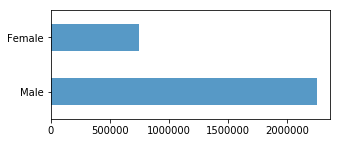

In [65]:
# gender distribution
combined[~combined.gender.isnull()].gender.value_counts().plot.barh(figsize = (5,2),alpha = 0.75)

In [146]:
ori = combined.copy()

In [153]:
combined = combined[(~combined.gender.isnull()) & (combined.usertype != "Dependent")]

# 2. Data Visualization

## a. Top 5 stations with the most starts (showing # of starts)

In [630]:
pd.DataFrame(combined.groupby(["from_station_id", "from_station_name"]).size()\
             .sort_values(ascending=False)[:5]).reset_index()\
             .rename(columns = {"from_station_id":"Station ID", "from_station_name":"Station Name", 0:"# of starts"})

,Station ID,Station Name,# of starts
0,35,Streeter Dr & Grand Ave,97571
1,76,Lake Shore Dr & Monroe St,53400
2,192,Canal St & Adams St,50911
3,91,Clinton St & Washington Blvd,49832
4,177,Theater on the Lake,47908


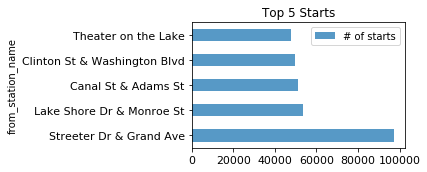

In [332]:
pd.DataFrame(combined.groupby(["from_station_name"]).size()\
             .sort_values(ascending=False)[:5])\
             .rename(columns = {0:"# of starts"}).plot.barh(fontsize = 11, title = "Top 5 Starts", 
                                                            figsize = (6,2.5), alpha = 0.75)
# plt.tight_layout()
# plt.savefig("../output/top5Starts.png")

## b. Trip duration by user type

In [15]:
def getDuration(x):
    trips = x['trip_id'].nunique()
    sum_dur = np.sum(x['end_time'] - x['start_time'])/ np.timedelta64(1, 'h') /24
    mean_dur = (x['end_time'] - x['start_time']).mean() / np.timedelta64(1, 'm')
    med_dur = (x['end_time'] - x['start_time']).median() / np.timedelta64(1, 'm')
    return [trips, sum_dur, mean_dur, med_dur]

In [16]:
trip_dur = pd.DataFrame(combined.groupby("usertype").apply(getDuration)).reset_index().rename(columns = {0:"Trip Information"})
trip_dur

,usertype,Trip Information
0,Customer,"[836861, 17977.886886574073, 30.93442858246666..."
1,Dependent,"[7, 0.06091435185185185, 12.53095238095, 13.4]"
2,Subscriber,"[2992135, 24372.93689814815, 11.72976123513333..."


In [17]:
def segInfo(x):
    x['# of Trips'] = x['Trip Information'][0]
    x['Total Duration (days)'] = x['Trip Information'][1]
    x['Mean Duration (min)'] = x['Trip Information'][2]
    x['Median Duration (min)'] = x['Trip Information'][3]
    return x

In [18]:
trip_dur = trip_dur.apply(segInfo, axis = 1)[['usertype','# of Trips','Total Duration (days)',
                                   'Mean Duration (min)','Median Duration (min)']]

In [19]:
trip_dur

,usertype,# of Trips,Total Duration (days),Mean Duration (min),Median Duration (min)
0,Customer,836861,17977.886887,30.934429,22.85
1,Dependent,7,0.060914,12.530952,13.40
2,Subscriber,2992135,24372.936898,11.729761,9.55


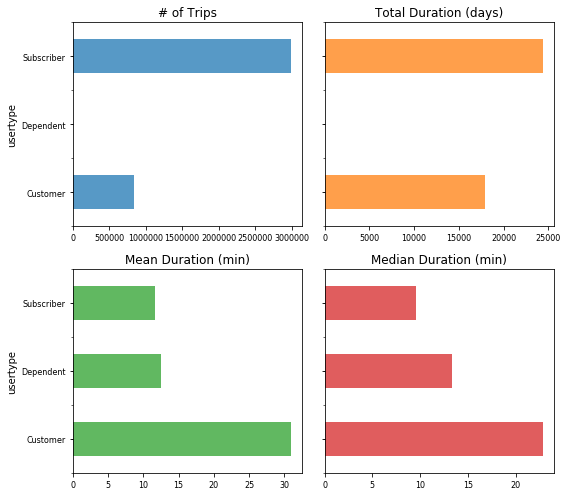

In [331]:
trip_dur.set_index("usertype").plot.barh(subplots = True, sharex = False, layout=(2,2), 
                                         figsize = (8,7), sharey = True, legend = False, fontsize = 8, 
                                         alpha = 0.75)
#plt.tight_layout()
#plt.savefig("../output/usertypes.png")

## c. Most popular trips based on start station and stop station

In [707]:
pd.DataFrame(combined.groupby(["from_station_name", "to_station_name"]).size().sort_values(ascending=False)[:5])\
    .reset_index().rename(columns = {0:"# of Trips"})

,from_station_name,to_station_name,# of Trips
0,Lake Shore Dr & Monroe St,Streeter Dr & Grand Ave,12171
1,Streeter Dr & Grand Ave,Streeter Dr & Grand Ave,10042
2,Streeter Dr & Grand Ave,Theater on the Lake,8180
3,Streeter Dr & Grand Ave,Lake Shore Dr & North Blvd,7993
4,Lake Shore Dr & North Blvd,Streeter Dr & Grand Ave,7226


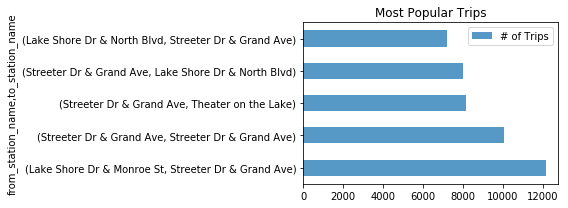

In [343]:
pd.DataFrame(combined.groupby(["from_station_name", "to_station_name"]).size().sort_values(ascending=False)[:5])\
    .rename(columns = {0:"# of Trips"}).plot.barh(alpha = .75, fontsize = 10, figsize = (8, 3), 
                                                  title = "Most Popular Trips")
# plt.tight_layout()
# plt.savefig("../output/toptrips.png")

> The most popular is from Lake Shore Dr & Monroe St to Streeter Dr & Grand Ave
<br> Streeter Dr & Grand Ave is right next to Navy Pier (a famous touristy spot with a series of shops and restaurants) so it makes sense that it appears as a stop in all of the top 5 trips. <br> Moreover, lakeshore is the scenic drive right along the pier. Bike-friendly and perfect for a pleasant short ride.

## d. Rider performance by Gender and Age based on avg trip distance (station to station), median speed (distance traveled / trip duration)

In [154]:
today = datetime.datetime.today()

In [155]:
combined['age'] = today.year - combined.birthyear

In [156]:
id_locs = ['id', 'latitude', 'longitude']

In [157]:
# add from station coordinates to df
new = combined.merge(stops[id_locs].rename(columns = dict(zip(id_locs, ["from_station_"+x for x in id_locs]))), 
                     on="from_station_id", how="left")

In [158]:
# add to station coordinates to df
new = new.merge(stops[id_locs].rename(columns = dict(zip(id_locs, ["to_station_"+x for x in id_locs]))), 
                     on="to_station_id", how="left")

In [159]:
R = 3961 # miles, earth radius
def distance(x):
    dlon = x['to_station_longitude'] - x['from_station_longitude']
    dlat = x['to_station_latitude'] - x['from_station_latitude']
    a = (math.sin(dlat/2))**2 + math.cos(x['from_station_latitude']) * math.cos(x['to_station_latitude']) * (math.sin(dlon/2))**2 
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a) ) 
    d = R * c
    return d

In [160]:
%%time
# calculate distance (miles)
new['distance'] = new.apply(distance, axis = 1)

CPU times: user 2min 43s, sys: 19.1 s, total: 3min 2s
Wall time: 4min 41s


In [161]:
%%time
# calculate duration (minutes): tripduration has nulls
new['duration'] = new.apply(lambda x: (x['end_time'] - x['start_time'])/ np.timedelta64(1, 'm'), axis = 1)

CPU times: user 2min 49s, sys: 18.9 s, total: 3min 8s
Wall time: 3min 34s


In [162]:
new['speed'] = new.distance/new.tripduration

In [33]:
# Rider performance by Gender and Age
new.groupby(["gender", pd.cut(new.age, range(0, int(new.age.max()), 5))]).agg({'distance':'mean', 'speed':'mean'})

distance     speed
gender age                             
Female (10, 15]     44.330429  0.085886
       (15, 20]     56.031956  0.083194
       (20, 25]     58.630159  0.081900
       (25, 30]     63.479342  0.083845
       (30, 35]     65.643909  0.084566
       (35, 40]     65.102701  0.084237
       (40, 45]     62.111926  0.082331
       (45, 50]     63.327784  0.080953
       (50, 55]     55.953414  0.075615
       (55, 60]     58.493101  0.075685
       (60, 65]     55.666894  0.073248
       (65, 70]     55.308673  0.069786
       (70, 75]     58.979863  0.061986
       (75, 80]     54.436759  0.053762
       (80, 85]     87.282205  0.084475
       (85, 90]     36.784853  0.065465
       (100, 105]   20.749898  0.035428
       (105, 110]   48.135597  0.090142
Male   (0, 5]       25.481642  0.021004
       (10, 15]     35.021926  0.057053
       (15, 20]     44.351472  0.086176
       (20, 25]     48.987959  0.085135
       (25, 30]     59.720609  0.090768
       (30, 35]     61.375676  0.091280
       (35, 40]     61.993346  0.091089
       (40, 45]     59.474554  0.088002
       (45, 50]     57.139597  0.086579
       (50, 55]     54.858041  0.084577
       (55, 60]     52.551013  0.080537
       (60, 65]     49.594828  0.075296
       (65, 70]     47.910473  0.074857
       (70, 75]     59.269700  0.076093
       (75, 80]     47.736813  0.065304
       (80, 85]     34.801240  0.054503
       (85, 90]     80.264360  0.074763
       (95, 100]    92.539379  0.090109
       (100, 105]  127.814450  0.137791
       (105, 110]  117.778861  0.109667
       (110, 115]   41.638479  0.046487

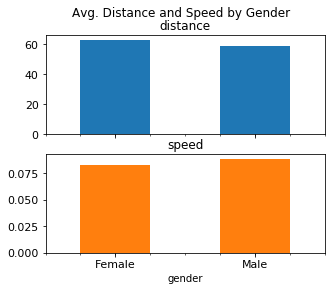

In [379]:
# Rider performance by Gender
new.groupby("gender").agg({'distance':'mean', 'speed':'mean'})\
    .plot.bar(rot=0, subplots=True, layout = (2,1), figsize = (5,4), 
              title = "Avg. Distance and Speed by Gender", fontsize = 11,
              legend = False)
plt.savefig("../output/rider_by_gender.png")

In [48]:
# check if the difference in distance is significant
stats.ttest_ind(new[new.gender == 'Female']['distance'].dropna(),new[new.gender == 'Male']['distance'].dropna(),
               equal_var=False)

Ttest_indResult(statistic=64.81688503899201, pvalue=0.0)

In [49]:
# check if the difference in speed is significant
stats.ttest_ind(new[new.gender == 'Female']['speed'].dropna(),new[new.gender == 'Male']['speed'].dropna(),
               equal_var=False)

Ttest_indResult(statistic=-148.29292204626196, pvalue=0.0)

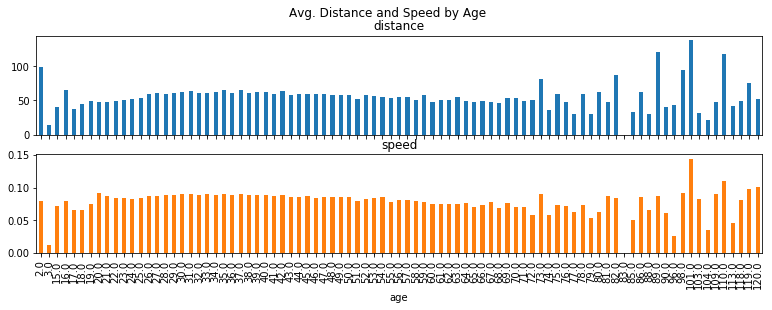

In [367]:
new.groupby("age").agg({'distance':'mean', 'speed':'mean'})\
    .plot.bar(rot=90, subplots=True, sharex=True, figsize = (13,4), title = "Avg. Distance and Speed by Age", 
              legend = False,
              fontsize = 10)
plt.savefig("../output/rider_by_age.png")

In [75]:
# check if the difference in distance is significant
(new[new.usertype == 'Customer'].dropna()['duration'].mean() - new[new.usertype == 'Subscriber'].dropna()['duration']\
     .mean())/(new[new.usertype == 'Subscriber'].dropna()['duration']\
               .var()/new.usertype.value_counts()['Subscriber']+new[new.usertype == 'Customer'].dropna()['duration']\
               .var()/new.usertype.value_counts()['Customer'])**(1/2)

130.20153396055045

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c3db36e80>,
      dtype=object)

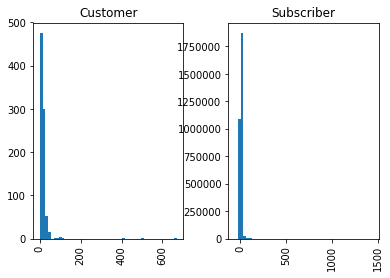

In [170]:
new['duration'].hist(by=new['usertype'], bins = 50)

> definitely different distributions

## e. What is the busiest bike in Chicago in 2017? How many times was it used? How many minutes was it in use?

In [392]:
# busiest by occupied duration (minutes)
new.groupby("bikeid").agg({"duration":["sum","size"]}).sort_values(by=("duration", "size"), ascending = False).head(5)

duration      
                 sum  size
bikeid                    
2565    22526.233333  1489
3308    17662.116667  1234
3489    17620.050000  1225
3128    18253.416667  1210
5880    20699.533333  1177

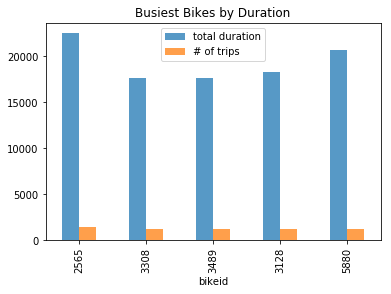

In [395]:
# busiest by occupied duration (minutes)
ax = new.groupby("bikeid").agg({"duration":["sum","size"]}).sort_values(by=("duration", "size"), ascending = False)\
    .head(5).plot.bar(title = "Busiest Bikes by Duration", alpha = .75)
ax.legend(['total duration', '# of trips'])
plt.savefig("../output/dur_busy.png")

In [391]:
# busiest by number of usage
new.groupby("bikeid").agg({"duration":["sum","size"]}).sort_values(by=("duration", "size"), ascending = False)\
    .head(5)

duration      
                 sum  size
bikeid                    
2565    22526.233333  1489
3308    17662.116667  1234
3489    17620.050000  1225
3128    18253.416667  1210
5880    20699.533333  1177

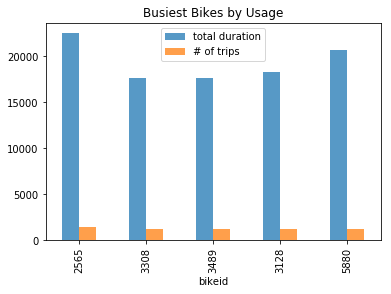

In [389]:
# busiest by number of usage
ax = new.groupby("bikeid").agg({"duration":["sum","size"]}).sort_values(by=("duration", "size"), ascending = False)\
    .head(5).plot.bar(title = "Busiest Bikes by Usage", alpha = .75)
ax.legend(['total duration', '# of trips'])
plt.savefig("../output/use_busy.png")

> The busiest bike in Chicago is #2565. It's been used 1,489 times for 22,526 minutes. (That's about 375 hours or 15.6 days.)

# 3. Data Cleaning

**a. What is the approach to deal with missing values, outliers, skewed data,mixed data type,etc:**

- Mixed data types -> Converting to dummies, or further features engineering

**bike ids** <br>
There seems to be a lot of bikes, it's hard to turn all of them into dummies. Thus a binned "popularity" index is created to capture the bike information. Some other non-categorical data are treated as such as well. Please refer to the feature engineering section.

In [43]:
# unique bike ids
new.bikeid.nunique()

6243

**stations** <br>
Same with bike ids, will be transformed under feature engineering.

In [83]:
# unique stations
new.from_station_id.nunique(), new.to_station_id.nunique()

(585, 585)

**user type**

In [171]:
interim = new.join(pd.get_dummies(new.usertype, prefix='dum'))

**stations** <br>
There are also a lot of stations so will probably just keep the distance data alone between all 585 stations.

In [172]:
coordinates = {}
for i in range(stops.shape[0]):
    coordinates[stops.iloc[i,:]['id']] = (stops.iloc[i,:]['latitude'], stops.iloc[i,:]['longitude'])

In [173]:
saved_dist = {}
for x in stops.id:
    for y in stops.id:
        if y == x:
            next
        else:
            dlon = coordinates[y][1] - coordinates[x][1]
            dlat = coordinates[y][0] - coordinates[x][0]
            a = (math.sin(dlat/2))**2 + math.cos(coordinates[x][0]) * math.cos(coordinates[y][0]) * (math.sin(dlon/2))**2 
            c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a) ) 
            d = R * c     
            saved_dist[(x,y)] = d

- Missing values

In [174]:
new.isnull().sum()/new.shape[0]

trip_id                   0.000000
start_time                0.000000
end_time                  0.000000
bikeid                    0.000000
tripduration              0.000000
from_station_id           0.000000
from_station_name         0.000000
to_station_id             0.000000
to_station_name           0.000000
usertype                  0.000000
gender                    0.000000
birthyear                 0.000083
age                       0.000083
from_station_latitude     0.000771
from_station_longitude    0.000771
to_station_latitude       0.000640
to_station_longitude      0.000640
distance                  0.001397
duration                  0.000000
speed                     0.001397
dtype: float64

Gender and age are missing pretty significantly. Both might be important as thus might be good to be filled in .

**Gender** <br>

I will fill it in with another class representing unknown. If missing gender are removed, then no actions needed.

interim['gender'] = interim.gender.fillna("Unkown")

In [175]:
interim = interim.join(pd.get_dummies(interim.gender, prefix='dum'))

In [176]:
interim.gender.value_counts()

Male      2245546
Female     746637
Name: gender, dtype: int64

**Age** <br>I will fill it in with the median since the distribution is quite skewed.

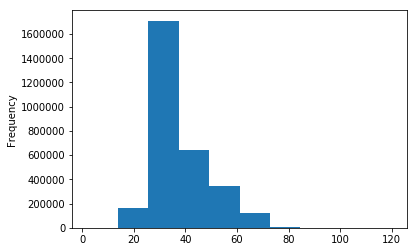

In [177]:
new.age.plot.hist()

In [178]:
interim['age'] = interim.age.fillna(interim.age.median())

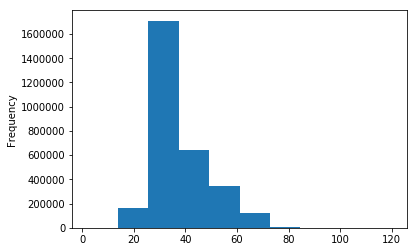

In [179]:
interim['age'].plot.hist()

**Distance**<br>
The data is pretty skewed. A more accurate might be to use trip duration to impute missing distance. (Most correlated in the set of original data)

However, since the missing distance data percentage is so low, we can remove the missing values.

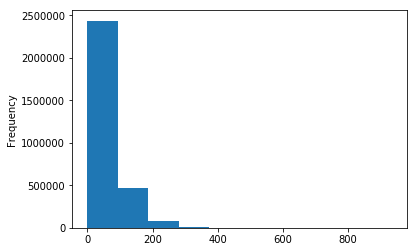

In [182]:
new.distance.plot.hist()

In [184]:
# duration is most related to distance
new.corr().loc['distance', :]

trip_id                  -0.006946
bikeid                    0.023251
tripduration              0.361705
from_station_id           0.048974
to_station_id             0.061514
birthyear                 0.035826
age                      -0.035826
from_station_latitude     0.078172
from_station_longitude   -0.018666
to_station_latitude       0.106317
to_station_longitude     -0.031955
distance                  1.000000
duration                  0.361618
speed                     0.530464
Name: distance, dtype: float64

In [198]:
# duration median to distance dictionary
dur_to_dist = interim.groupby("duration").distance.median().to_dict()

In [35]:
# impute distance based on duration of the trip
interim['new_dist']  = interim.apply(lambda x: dur_to_dist[x['duration']] if math.isnan(x['distance']) else x['distance'], axis = 1)

In [185]:
# just remove missing values
interim = interim[~interim.distance.isnull()]

**Finalized list of features (before feature engineering)**<br>
Speed is not included because it's a calcualted field. It will be correlated with the features that generated it.

In [189]:
interim[['bikeid',
       'from_station_id', 'to_station_id',
       'dum_Customer', 'dum_Subscriber',
       'dum_Female', 'dum_Male',  'age']].isnull().sum()

bikeid             0
from_station_id    0
to_station_id      0
dum_Customer       0
dum_Subscriber     0
dum_Female         0
dum_Male           0
age                0
dtype: int64

**b.What assumptions did you make as you cleaned your data:**

1. Distance and duration are somewhat related (23%), and thus can be used to fill in the gaps <br>
2. Age is more than 20% missing, and yet we are still using them as features, assuming that majority of the values are somewhat close to its median.<br>
3. Gender is more than 20% missing, and yet we are still using them as features, assuming that it will prove to be an important feature.
4. Skewed data is represented of the overall population and the model will be able to deal with skewness.

## 3.1 Data Exploration

In [190]:
interim.shape

(2988002, 24)

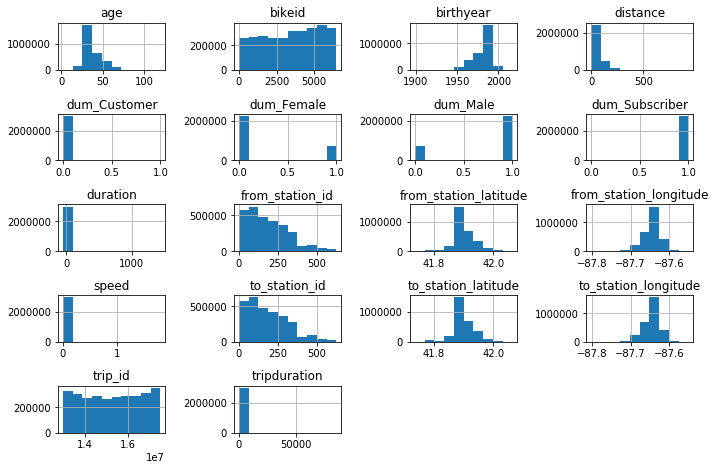

In [191]:
interim.hist(figsize = (10,10), layout = (8,4))
plt.tight_layout()
#plt.savefig("../output/features.png")

## 3.2 Feature Engineering

**Time related information**

In [192]:
interim['month'] = interim.start_time.apply(lambda x: x.month)

In [193]:
interim['start_hour'] = interim.start_time.apply(lambda x: x.hour)

**Checking Duration**

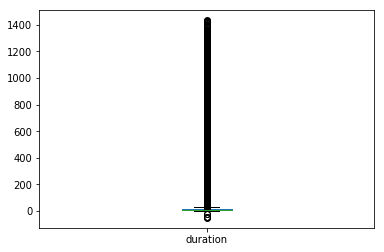

In [194]:
interim.duration.plot.box()

In [196]:
# there should not be negative durations
interim[interim.duration < 0][['tripduration', 'duration', 'start_time', 'end_time', 
                                  'from_station_name', 'to_station_name', 'distance']]

,tripduration,duration,start_time,end_time,from_station_name,to_station_name,distance
2672341,831,-46.0,2017-11-05 01:59:00,2017-11-05 01:13:00,Sheffield Ave & Webster Ave,Broadway & Barry Ave,66.546296
2672342,887,-45.0,2017-11-05 01:58:00,2017-11-05 01:13:00,Morgan St & Lake St,Michigan Ave & Lake St,56.073177
2672343,479,-52.0,2017-11-05 01:56:00,2017-11-05 01:04:00,Broadway & Argyle St,Sheridan Rd & Montrose Ave,48.857838
2672344,932,-44.0,2017-11-05 01:51:00,2017-11-05 01:07:00,Halsted St & Wrightwood Ave,Wood St & Milwaukee Ave,95.816518
2672345,1028,-43.0,2017-11-05 01:47:00,2017-11-05 01:04:00,Ashland Ave & Division St,Racine Ave & 15th St,168.558121
2672357,2158,-24.0,2017-11-05 01:29:00,2017-11-05 01:05:00,Larrabee St & Webster Ave,Lake Shore Dr & Monroe St,170.302042
2672363,2385,-20.0,2017-11-05 01:24:00,2017-11-05 01:04:00,Larrabee St & Webster Ave,Lake Shore Dr & Monroe St,170.302042


In [199]:
# reverse duration:distance dictionary
dist_to_dur = {v: k for k, v in dur_to_dist.items()}

In [200]:
# impute distance based on duration of the trip
interim['duration']  = interim.apply(lambda x: dist_to_dur[x['distance']] if x['duration'] < 0 else x['duration'], axis = 1)

In [202]:
# doesn't seem to be any ride that's over a day so everything else seems reasonable
interim[interim.duration > 24*60][['tripduration', 'duration', 'start_time', 'end_time', 
                                  'from_station_name', 'to_station_name', 'distance']]

,tripduration,duration,start_time,end_time,from_station_name,to_station_name,distance


In [203]:
interim.duration.describe()

count    2.988002e+06
mean     1.172911e+01
std      1.588218e+01
min     -5.200000e+01
25%      6.000000e+00
50%      9.550000e+00
75%      1.505000e+01
max      1.434933e+03
Name: duration, dtype: float64

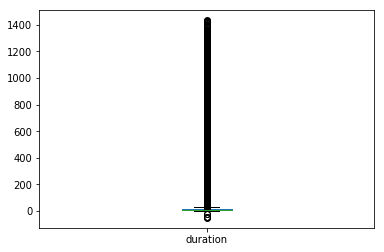

In [204]:
interim.duration.plot.box()

**Binning categorical variables into scalars using its popularity (usage/frequency)**

In [205]:
def fromPopularity(x):
    """8 levels of popularity, the higher the more popular
    input: column name
    ouput: level of popularity
    """
    if _counts[x] == _freq['min']:
        return 0
    elif _counts[x] < _freq['25%']:
        return 1
    elif _counts[x] == _freq['25%']:
        return 2
    elif _counts[x] < _freq['50%']:
        return 3
    elif _counts[x] == _freq['50%']:
        return 4
    elif _counts[x] < _freq['75%']:
        return 5
    elif _counts[x] == _freq['75%']:
        return 6
    elif _counts[x] < _freq['max']:
        return 7
    else:
        return 8

In [206]:
_counts = 0
_freq = 0
def createPopularity(col):
    global _counts
    global _freq
    _counts = interim[col].value_counts()
    _freq = _counts.describe()
        #data = [[( interim[col])] ,[_counts] * interim.shape[0], [_freq] * interim.shape[0]]
        #data = [[(interim[col])], _counts, _freq]
    with Pool(mp.cpu_count() - 1) as pool:
        interim[col.replace("_station_id", "")+'_popularity'] = pool.map(fromPopularity, interim[col])
        pool.terminate()

- Most popular bikes

In [207]:
%%time
createPopularity("bikeid")

CPU times: user 1.25 s, sys: 431 ms, total: 1.68 s
Wall time: 2min 47s


- Most popular start stations

In [208]:
%%time
createPopularity("to_station_id")

CPU times: user 1.29 s, sys: 364 ms, total: 1.65 s
Wall time: 3min 36s


- Most popular destination stations

In [209]:
%%time
createPopularity('from_station_id')

CPU times: user 1.23 s, sys: 279 ms, total: 1.51 s
Wall time: 3min 18s


- Most popular hour (traffic)

In [210]:
%%time
createPopularity('start_hour')

CPU times: user 1.12 s, sys: 214 ms, total: 1.34 s
Wall time: 2min 47s


- Most popular month (?)

In [211]:
%%time
createPopularity('month')

CPU times: user 1.13 s, sys: 269 ms, total: 1.4 s
Wall time: 2min 58s


- Check for multicollinearily

**Finalized list of features**

In [299]:
# dropped base level for dummies
features = ['distance', 'age', 
       'dum_Male',
       'dum_Subscriber',
       'from_popularity', 'bikeid_popularity', 'to_popularity','start_hour_popularity', 'month_popularity']

In [300]:
interim[features].isnull().sum()

distance                 0
age                      0
dum_Male                 0
dum_Subscriber           0
from_popularity          0
bikeid_popularity        0
to_popularity            0
start_hour_popularity    0
month_popularity         0
dtype: int64

label = 'duration'

# 4. Modeling
He would like Divvy Bike to add a new feature to their kiosks: “Enter a destination and we’ll tell you how long the trip will take”.

We need you to build a model that can predict how long a trip will take given a starting point and destination. You will need to get creative about the factors that will predict travel time. (Optional: find and use additional datasets that may have an impact on travel time, like weather and traffic).

## Regression Models

In [306]:
def train_test_wstd(data, std = False, features = features):
    """Train, test split with standardization option"""
    # without base levels of categories
    X = data[features].reset_index(drop=True)
    Y = data['duration'].reset_index(drop=True)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)
    if std:
        X_train_std, X_test_std = standardize(X_train, X_test)
    return X_train, X_test, X_train_std, X_test_std, y_train, y_test

In [219]:
def standardize(X_train, X_test):
    scl = StandardScaler(copy=True, with_mean=True, with_std=True)
    scale = scl.fit(X_train)
    data_std = scale.transform(X_train)
    test_std = scale.transform(X_test)
    return data_std, test_std

### Train Test Split with standardization

In [307]:
X_train, X_test, X_train_std, X_test_std, y_train, y_test = train_test_wstd(interim, std = True)

/Users/ez/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/Users/ez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


### Linear Regression Model (baseline)

In [308]:
X2 = sm.add_constant(X_train_std)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                 3.848e+04
Date:                Tue, 09 Jul 2019   Prob (F-statistic):               0.00
Time:                        14:59:59   Log-Likelihood:            -9.2114e+06
No. Observations:             2241001   AIC:                         1.842e+07
Df Residuals:                 2240991   BIC:                         1.842e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7262      0.010   1189.845      0.0

In [311]:
lr = LinearRegression()
lr1 = LinearRegression.fit(lr, X = X_train_std, y = y_train)
# Score of the linear model
lr1.score(X = X_test_std, y = y_test)

0.1309287019751887

In [312]:
# MSE
print("MSE on training set: {}".format(sum((lr1.predict(X = X_train_std) - y_train)**2)/len(y_train)))
print("MSE on test set: {}".format(sum((lr1.predict(X = X_test_std) - y_test)**2)/len(y_test)))

MSE on training set: 217.6562857426769
MSE on test set: 221.69444761488418


### GBT Model

In [313]:
gbrt = GradientBoostingRegressor(random_state=0)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [314]:
print("accuracy on training set: %f" % gbrt.score(X_train, y_train))
print("accuracy on test set: %f" % gbrt.score(X_test, y_test))

accuracy on training set: 0.152587
accuracy on test set: 0.145783


In [315]:
print("MSE on training set: {}".format(sum((gbrt.predict(X_train) - y_train)**2)/len(y_train)))
print("MSE on test set: {}".format(sum((gbrt.predict(X_test) - y_test)**2)/len(y_test)))

MSE on training set: 212.949539525987
MSE on test set: 217.9051263137011


([<matplotlib.axis.YTick at 0x1c6862f5c0>,
 <a list of 9 Text yticklabel objects>)

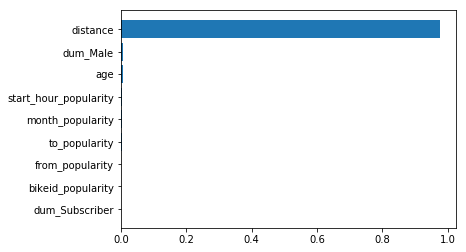

In [316]:
plt.barh(range(len(features)),sorted(gbrt.feature_importances_))
plt.yticks(range(len(features)), tuple(X_test.columns[np.argsort(gbrt.feature_importances_)]))

<Figure size 720x720 with 0 Axes>

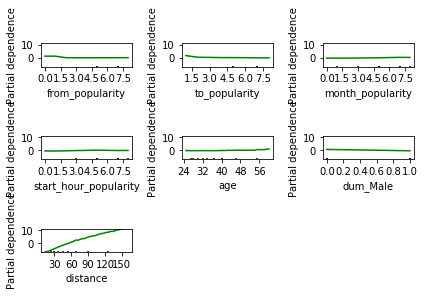

In [317]:
plt.figure(figsize=(10,10))
fig, axs = plot_partial_dependence(gbrt, X_train, np.argsort(gbrt.feature_importances_)[-7:],
                                       feature_names=X_train.columns,
                                       n_jobs=4, grid_resolution=80)
plt.tight_layout()

# Understanding Important Variables

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c44e347b8>,
      dtype=object)

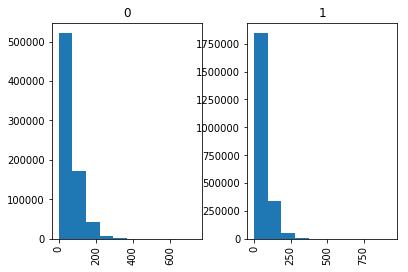

In [229]:
interim.distance.hist(by=interim.dum_Male)

# 6. Bring in external data

In [318]:
weather = pd.read_csv("../data/external/Beach_Weather_Stations_-_Automated_Sensors_-_2017_-_Air_Temperature.csv", 
                     parse_dates = ['Measurement Timestamp'])

In [231]:
weather.shape

(25154, 18)

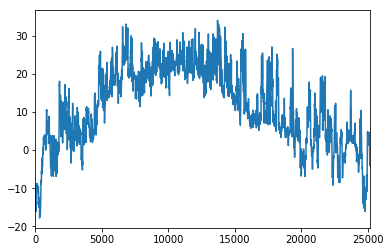

In [232]:
# look into the data
weather[weather['Station Name'] == '63rd Street Weather Station']['Air Temperature'].plot()

In [59]:
weather.columns

Index(['Station Name', 'Measurement Timestamp', 'Air Temperature',
       'Wet Bulb Temperature', 'Humidity', 'Rain Intensity', 'Interval Rain',
       'Total Rain', 'Precipitation Type', 'Wind Direction', 'Wind Speed',
       'Maximum Wind Speed', 'Barometric Pressure', 'Solar Radiation',
       'Heading', 'Battery Life', 'Measurement Timestamp Label',
       'Measurement ID'],
      dtype='object')

In [319]:
weather_feature = ['Measurement Timestamp', 'Air Temperature',
       'Humidity', 'Rain Intensity', 'Interval Rain',
       'Total Rain', 'Precipitation Type', 'Wind Direction', 'Wind Speed',
       'Maximum Wind Speed', 'Barometric Pressure', 'Solar Radiation']

In [320]:
weather_cat = ['Precipitation Type', 'Wind Direction']

In [321]:
weather_max = weather.groupby("Measurement Timestamp").agg(dict(zip(weather_cat, [max]*len(weather_cat)))).reset_index()

In [322]:
weather_mean = weather[list(set(weather_feature) - set(weather_cat))].groupby("Measurement Timestamp").mean().reset_index()

In [323]:
weather_new = weather_max.merge(weather_mean, on="Measurement Timestamp")

In [324]:
weather_new[weather_feature].isnull().sum()

Measurement Timestamp    0
Air Temperature          0
Humidity                 0
Rain Intensity           5
Interval Rain            0
Total Rain               5
Precipitation Type       5
Wind Direction           0
Wind Speed               0
Maximum Wind Speed       0
Barometric Pressure      0
Solar Radiation          0
dtype: int64

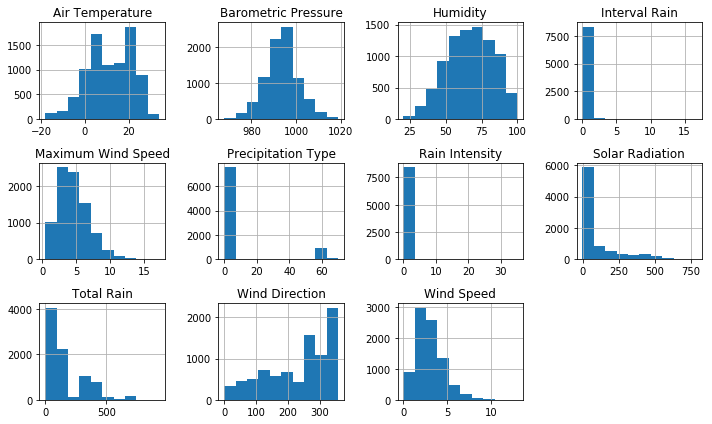

In [239]:
weather_new[weather_feature].hist(layout = (3, 4), figsize = (10, 6))
plt.tight_layout()

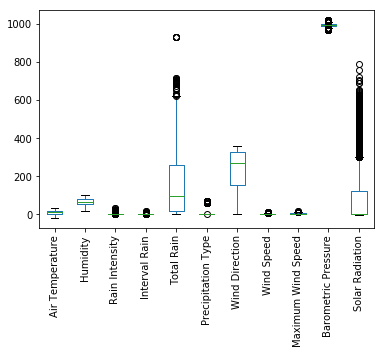

In [162]:
weather_new[weather_feature].drop('Measurement Timestamp', axis = 1).plot.box(rot= 90)

In [405]:
weather_new.columns

Index(['Measurement Timestamp', 'Precipitation Type', 'Wind Direction',
       'Humidity', 'Maximum Wind Speed', 'Barometric Pressure',
       'Air Temperature', 'Total Rain', 'Solar Radiation', 'Wind Speed',
       'Rain Intensity', 'Interval Rain'],
      dtype='object')

In [325]:
# forward fill missing values
weather_new = weather_new.ffill()

In [326]:
w_feature = ['Air Temperature', 'Total Rain', 'Wind Speed']

In [327]:
# merge weather data with original data
in_n_out = pd.merge_asof(interim[features + ["start_time", "duration"]].sort_values("start_time"),
                         weather_new[['Measurement Timestamp'] + w_feature]\
                         .sort_values('Measurement Timestamp'),
                         left_on = "start_time", right_on = "Measurement Timestamp")
                                                   #on = 'half_hour', how = "left")

In [328]:
in_n_out.isnull().sum()

distance                 0
age                      0
dum_Male                 0
dum_Subscriber           0
from_popularity          0
bikeid_popularity        0
to_popularity            0
start_hour_popularity    0
month_popularity         0
start_time               0
duration                 0
Measurement Timestamp    0
Air Temperature          0
Total Rain               0
Wind Speed               0
dtype: int64

## Remodeling with external data

### Train Test Split with standardization

In [329]:
X_train2, X_test2, X_train_std2, X_test_std2, y_train2, y_test2 = train_test_wstd(in_n_out\
            .drop(['start_time','Measurement Timestamp'], axis = 1), std = True, features=features+w_feature)

/Users/ez/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/Users/ez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


### Linear Regression Model (baseline)

In [330]:
X2 = sm.add_constant(X_train_std2)
est = sm.OLS(y_train2, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                 2.871e+04
Date:                Tue, 09 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:23:26   Log-Likelihood:            -9.2181e+06
No. Observations:             2241001   AIC:                         1.844e+07
Df Residuals:                 2240988   BIC:                         1.844e+07
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7263      0.010   1186.313      0.0

In [331]:
lr = LinearRegression()
lr2 = LinearRegression.fit(lr, X = X_train_std2, y = y_train2)
# Score of the linear model
lr2.score(X = X_test_std2, y = y_test2)

0.13464179187580394

In [286]:
# MSE
print("MSE on training set: {}".format(sum((lr2.predict(X = X_train_std2) - y_train2)**2)/len(y_train2)))
print("MSE on test set: {}".format(sum((lr2.predict(X = X_test_std2) - y_test2)**2)/len(y_test2)))

MSE on training set: 218.85771640038507
MSE on test set: 217.2148315533426


### GBT Model

In [332]:
gbrt = GradientBoostingRegressor(random_state=0)
gbrt.fit(X_train2, y_train2)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [333]:
print("accuracy on training set: %f" % gbrt.score(X_train2, y_train2))
print("accuracy on test set: %f" % gbrt.score(X_test2, y_test2))

accuracy on training set: 0.150762
accuracy on test set: 0.148742


In [334]:
print("MSE on training set: {}".format(sum((gbrt.predict(X_train2) - y_train2)**2)/len(y_train2)))
print("MSE on test set: {}".format(sum((gbrt.predict(X_test2) - y_test2)**2)/len(y_test2)))

MSE on training set: 214.53536377714468
MSE on test set: 213.7603702397294


([<matplotlib.axis.YTick at 0x1c68177198>,
 <a list of 12 Text yticklabel objects>)

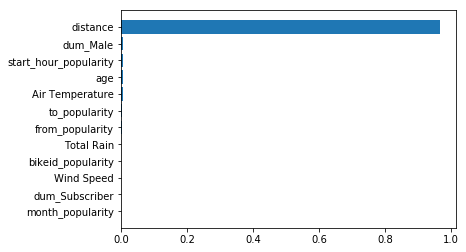

In [336]:
plt.barh(range(len(features+w_feature)),sorted(gbrt.feature_importances_))
plt.yticks(range(len(features+w_feature)), tuple(X_test2.columns[np.argsort(gbrt.feature_importances_)]))

<Figure size 720x720 with 0 Axes>

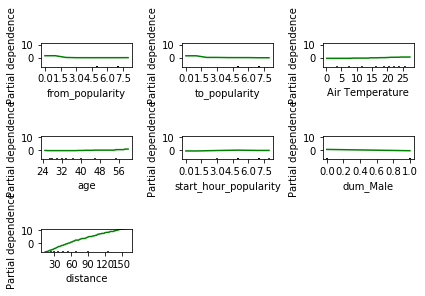

In [337]:
plt.figure(figsize=(10,10))
fig, axs = plot_partial_dependence(gbrt, X_train2, np.argsort(gbrt.feature_importances_)[-7:],
                                       feature_names=X_train2.columns,
                                       n_jobs=4, grid_resolution=80)
plt.tight_layout()

# Other models
- Random Forest

In [339]:
rdm = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=100,
           max_features=8, max_leaf_nodes=100, random_state=0,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=15)
rdm.fit(X_train, y_train)
print("accuracy on training set: %f" % rdm.score(X_train, y_train))
print("accuracy on test set: %f" % rdm.score(X_test, y_test))

accuracy on training set: 0.182039
accuracy on test set: 0.137065


In [340]:
rdm.fit(X_train2, y_train2)
print("accuracy on training set: %f" % rdm.score(X_train2, y_train2))
print("accuracy on test set: %f" % rdm.score(X_test2, y_test2))

accuracy on training set: 0.196984
accuracy on test set: 0.142731


([<matplotlib.axis.YTick at 0x1caaa02ac8>,
 <a list of 12 Text yticklabel objects>)

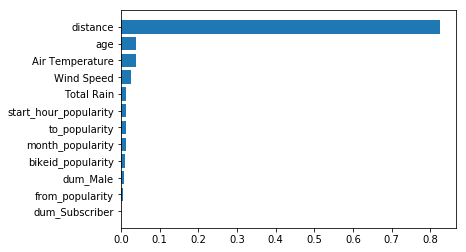

In [342]:
plt.barh(range(len(features+w_feature)),sorted(rdm.feature_importances_))
plt.yticks(range(len(features+w_feature)), tuple(X_test2.columns[np.argsort(rdm.feature_importances_)]))

# Key Takeaways

1. Distance is by far the most predictive among all variables. The longer the distance, the longer the trip duration.
- Other variables that are important and make sense are age (older the age, longer the duration), and gender (Males take slighly shorter time to finish trips).
2. Weather data can improve the model accuracy but only by a little bit.
3. Gradient boosted tree model with weather info is the most accurate (R-squared = 14.8%), and yet it is not that much better than without weather data, or a linear model.